<a href="https://colab.research.google.com/github/eip4-mars/EIP4P2/blob/master/Session5/Human_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper Ref: [https://arxiv.org/pdf/1804.06208.pdf](https://arxiv.org/pdf/1804.06208.pdf)

Training module : [Github](https://github.com/Microsoft/human-pose-estimation.pytorch)


In [1]:
!git clone https://github.com/microsoft/human-pose-estimation.pytorch.git 
!mv /content/human-pose-estimation.pytorch/* .
!rm -rf /content/human-pose-estimation.pytorch

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 68.78 KiB | 9.83 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!cp /content/gdrive/My\ Drive/pose_resnet_50_256x256.pth.tar .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import sys
sys.path.append("/content/lib")

In [4]:
import torch
import models 
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from core.config import config
from core.config import update_config



In [5]:
CONFIG_FILE = '/content/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'
update_config(CONFIG_FILE)

In [12]:
update_config(CONFIG_FILE)
device=torch.device('cpu')
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

<All keys matched successfully>

In [ ]:
from torchsummary import summary
use_cuda= torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')
print(device)
model = model.to(device)
summary(model, input_size=(3,256,256))
#model

In [9]:
!git clone https://github.com/waleedka/hiddenlayer.git


Cloning into 'hiddenlayer'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 364 (delta 2), reused 3 (delta 0), pack-reused 355
Receiving objects: 100% (364/364), 4.47 MiB | 33.17 MiB/s, done.
Resolving deltas: 100% (183/183), done.


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:438: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


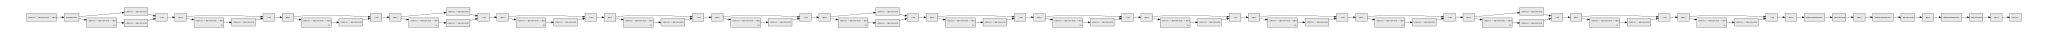

In [13]:
from hiddenlayer import hiddenlayer as hl
hl.build_graph(model, torch.zeros([1, 3, 256, 256]))

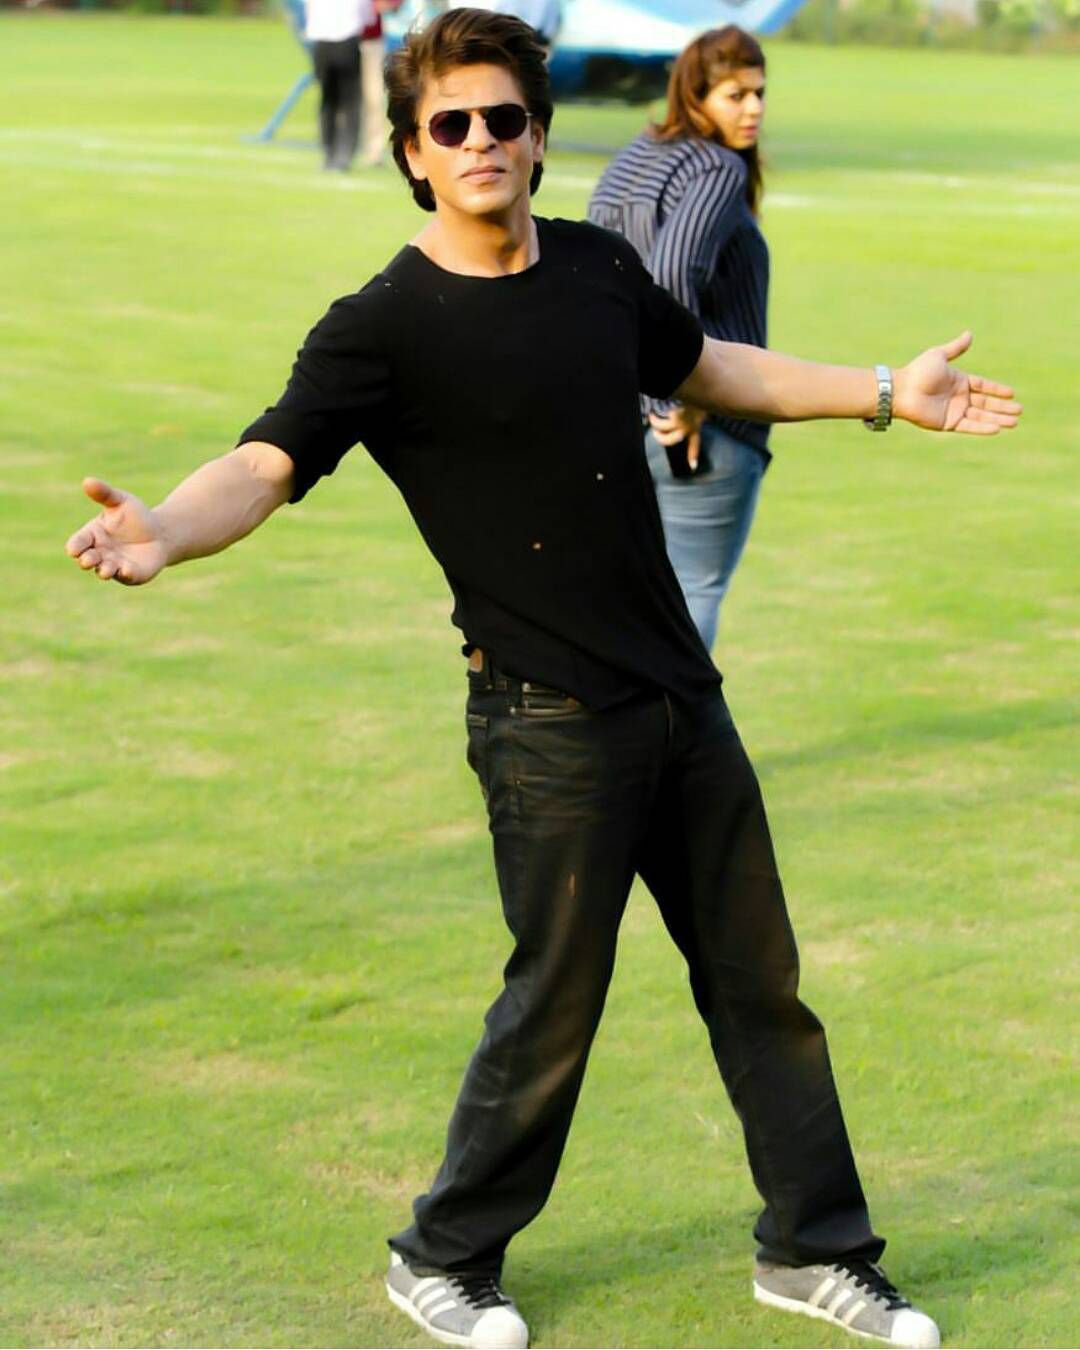

In [ ]:
IMPATH = 'srk_pose.jpg'
im = Image.open(IMPATH).convert('RGB')
im_Sq = im.resize((400,400))
im

In [ ]:
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

In [ ]:
im_in = transform(im_Sq)
output = model(im_in.unsqueeze(0)).squeeze()

In [ ]:
joints = output.detach().numpy()
in_W,in_H = im.size
out_W, out_H  = joints.shape[1:]

In [ ]:
body_points = ['r-ankle','r-knee','r-hip','l-hip','l-knee','l-ankle','pelvis','thorax','upper-neck','head-top','r-wrist','r-elbow','r-shoulder','l-shoulder','l-elbow','l-wrist']
for i, val in enumerate(body_points):
    print(str(i).rjust(2,' '),':',  val)

 0 : r-ankle
 1 : r-knee
 2 : r-hip
 3 : l-hip
 4 : l-knee
 5 : l-ankle
 6 : pelvis
 7 : thorax
 8 : upper-neck
 9 : head-top
10 : r-wrist
11 : r-elbow
12 : r-shoulder
13 : l-shoulder
14 : l-elbow
15 : l-wrist


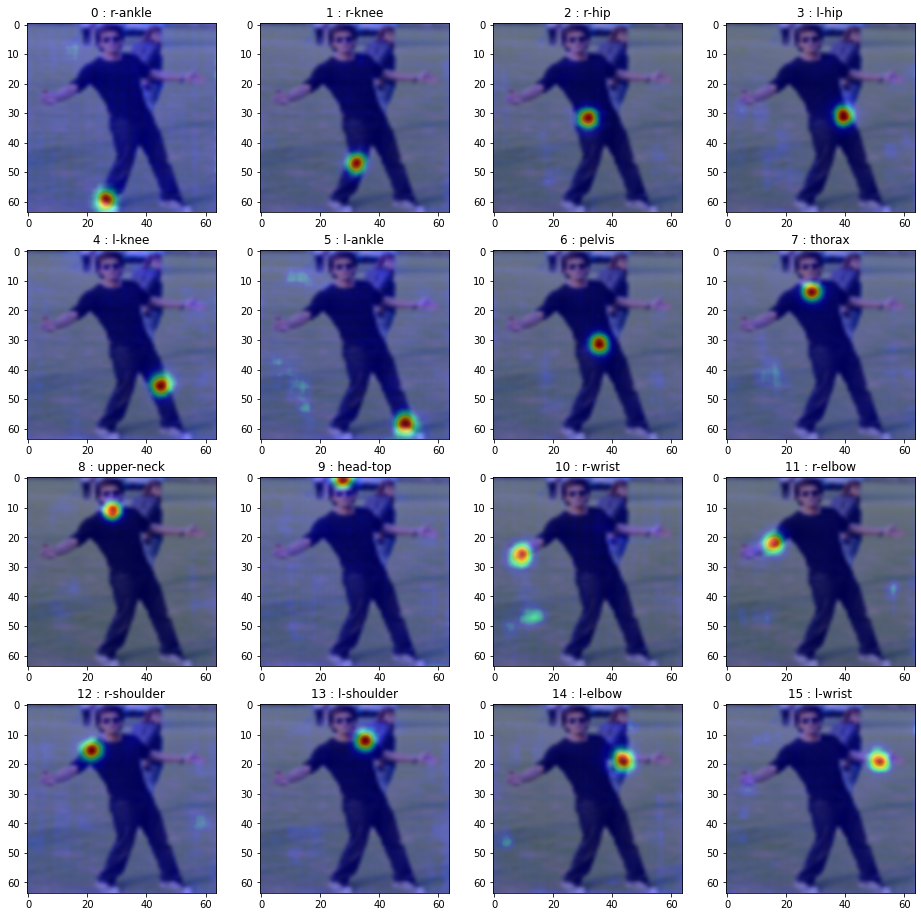

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(im.resize((out_W, out_H)),cmap = 'gray', interpolation='bicubic')  ## as output shape is 64x64
    plt.imshow(joints[i], alpha=0.5, cmap = 'jet', interpolation='bicubic')
    #plt.axis('off')
    plt.title(str(i) + ' : ' +body_points[i])
plt.show()

In [ ]:
THRESHOLD = 0.7

joints_centres = []

for i in range(joints.shape[0]):
    hottest_areas = np.ma.MaskedArray(joints[i], joints[i] < THRESHOLD)
    joint_centre = hottest_areas.nonzero()[0].mean(),hottest_areas.nonzero()[1].mean()
    if np.isnan(joint_centre[1]): joint_centre = np.nan, np.nan
    joints_centres.append(joint_centre)


In [ ]:
joints_centres

[(59.333333333333336, 26.11111111111111),
 (47.0, 32.0),
 (31.88888888888889, 31.444444444444443),
 (31.2, 38.92),
 (45.5, 44.5),
 (58.22222222222222, 48.5),
 (31.38888888888889, 35.333333333333336),
 (14.0, 28.5),
 (11.384615384615385, 28.384615384615383),
 (0.625, 27.25),
 (26.0, 9.166666666666666),
 (22.153846153846153, 15.538461538461538),
 (15.5, 21.22222222222222),
 (12.0, 35.0),
 (18.714285714285715, 43.42857142857143),
 (19.0, 51.2)]

In [ ]:
#print(joints_centres)

conv_W = lambda x : np.nan if np.isnan(x) else round(x * in_W / out_W)
conv_H = lambda x : np.nan if np.isnan(x) else round(x * in_H / out_H)

final_points = [(conv_W(point[1]),conv_H(point[0])) for point in joints_centres]
print(joints_centres)
print(final_points)

[(59.333333333333336, 26.11111111111111), (47.0, 32.0), (31.88888888888889, 31.444444444444443), (31.2, 38.92), (45.5, 44.5), (58.22222222222222, 48.5), (31.38888888888889, 35.333333333333336), (14.0, 28.5), (11.384615384615385, 28.384615384615383), (0.625, 27.25), (26.0, 9.166666666666666), (22.153846153846153, 15.538461538461538), (15.5, 21.22222222222222), (12.0, 35.0), (18.714285714285715, 43.42857142857143), (19.0, 51.2)]
[(441.0, 1252.0), (540.0, 991.0), (531.0, 673.0), (657.0, 658.0), (751.0, 960.0), (818.0, 1228.0), (596.0, 662.0), (481.0, 295.0), (479.0, 240.0), (460.0, 13.0), (155.0, 548.0), (262.0, 467.0), (358.0, 327.0), (591.0, 253.0), (733.0, 395.0), (864.0, 401.0)]


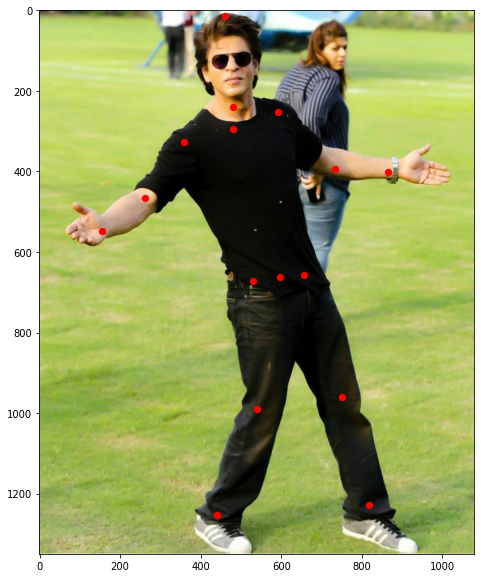

In [ ]:
#### Plot points on initial image
im = Image.open(IMPATH).convert('RGB')
x_pts = [pt[0] for pt in final_points if not np.isnan(pt[0])]
y_pts = [pt[1] for pt in final_points if not np.isnan(pt[0])]
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.scatter(x_pts, y_pts, c='r', s=40)
plt.show()

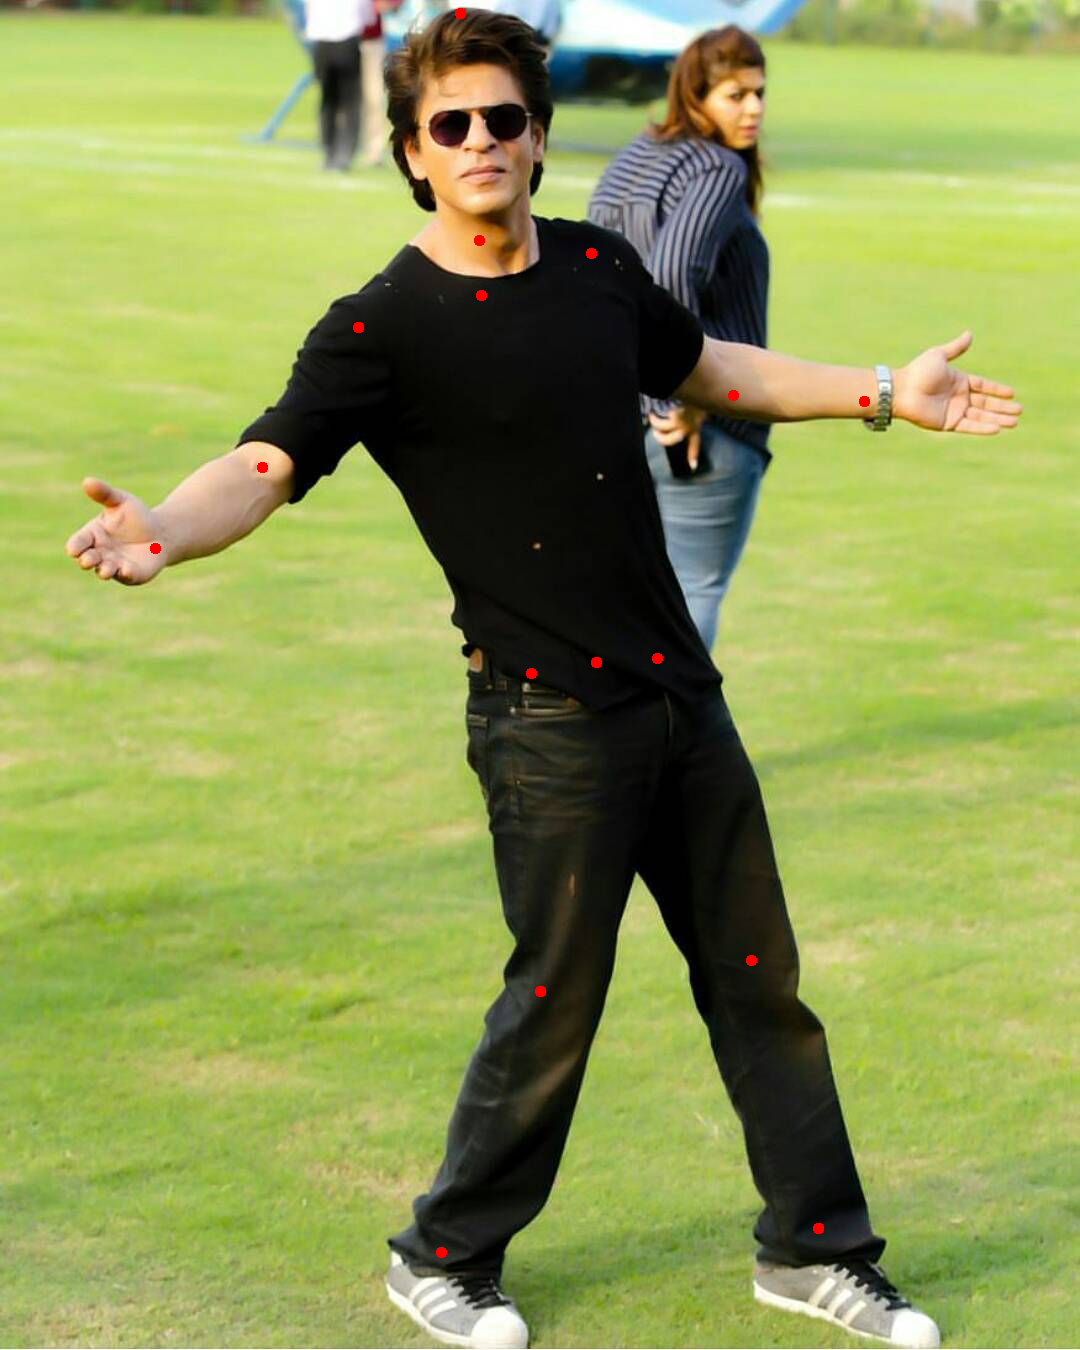

In [ ]:
##### Plot joints on input image in PIL
im = Image.open(IMPATH).convert('RGB')
draw = ImageDraw.Draw(im)
r=5
for x,y in final_points:
    if not np.isnan(x):
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill='red')
del draw
im

 0 : r-ankle
 1 : r-knee
 2 : r-hip
 3 : l-hip
 4 : l-knee
 5 : l-ankle
 6 : pelvis
 7 : thorax
 8 : upper-neck
 9 : head-top
10 : r-wrist
11 : r-elbow
12 : r-shoulder
13 : l-shoulder
14 : l-elbow
15 : l-wrist


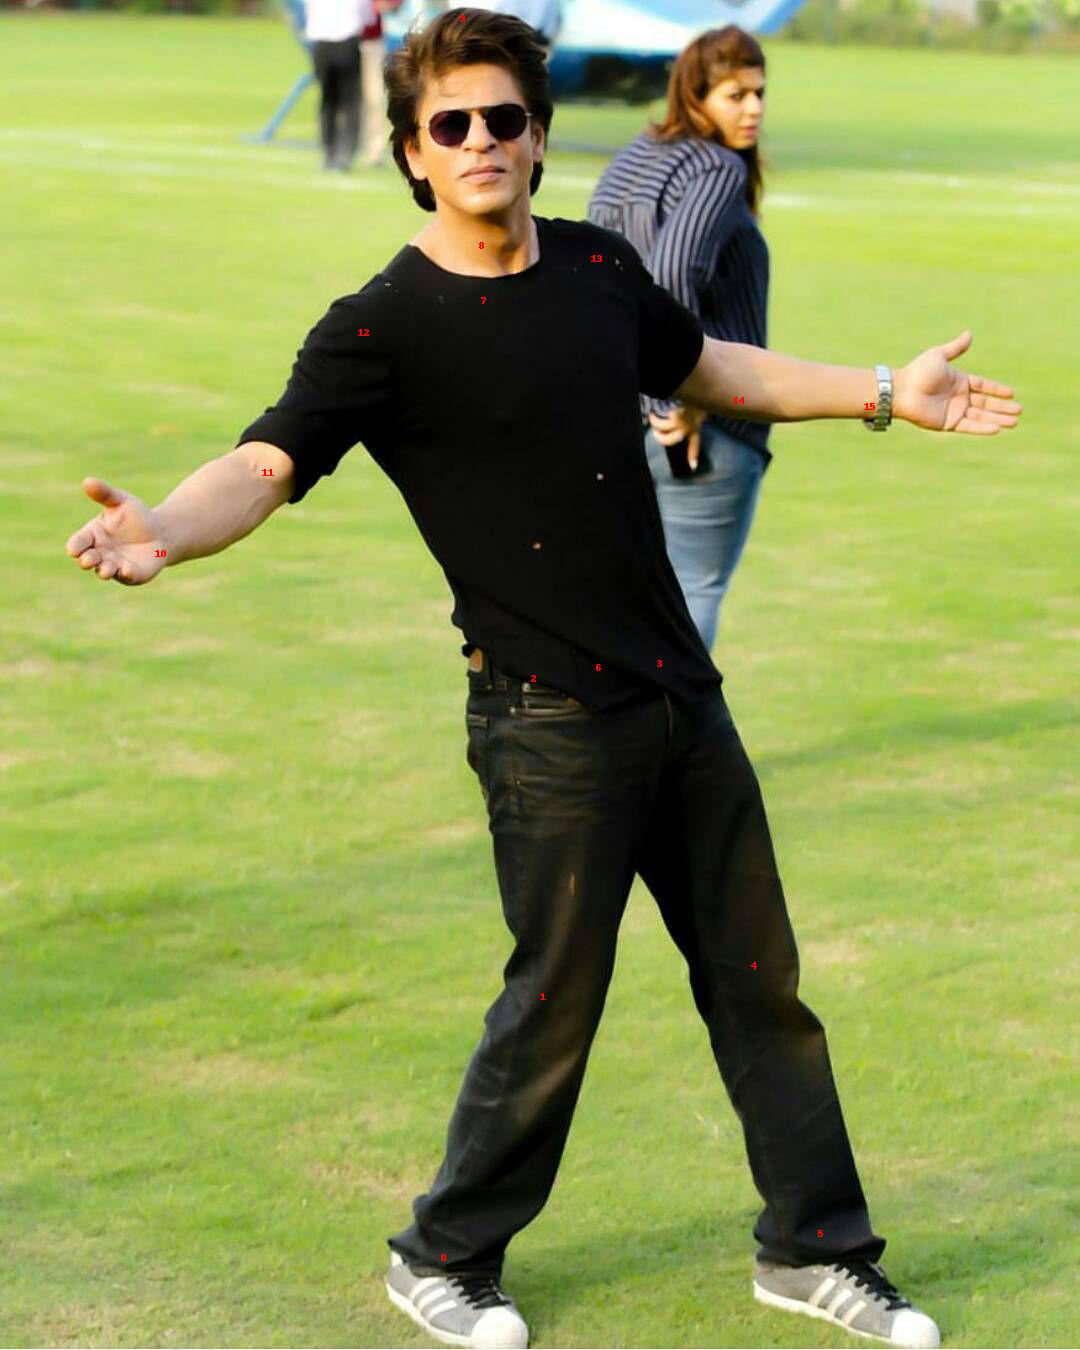

In [ ]:
##### Plot joint labels with number
im = Image.open(IMPATH).convert('RGB')
draw = ImageDraw.Draw(im)
r=5
for i in range(len(final_points)):
    if not np.isnan(final_points[i][0]):
        draw.text(final_points[i], str(i), fill = 'red')
del draw
for i, val in enumerate(body_points):
    print(str(i).rjust(2,' '),':',  val)
im

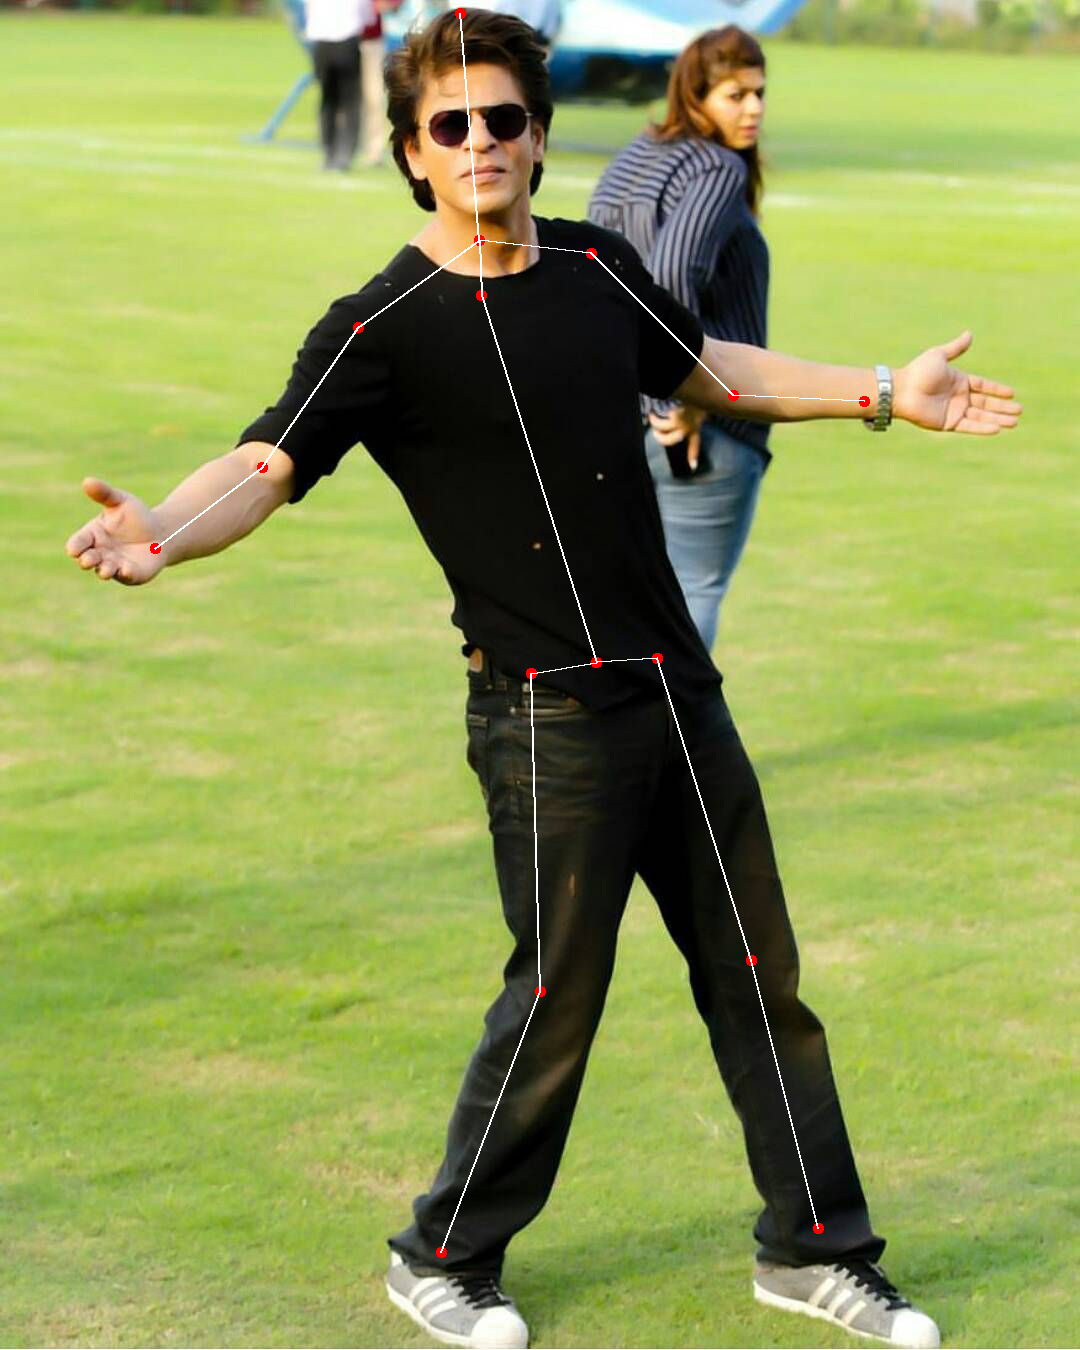

In [ ]:
##### Plot joints and connections on input image in PIL
CONNECTIONS = [
               ## lower half
               [0,1],
               [1,2],
               [2,6],
               [5,4],
               [4,3],
               [3,6],
               ## Upper Half
               [10,11],
               [11,12],
               [12,8],
               [15,14],
               [14,13],
               [13,8],
               [8,7],
               [8,9],
               ## Connection
               [7,6]
]

##### Plot joints on input image in PIL
im = Image.open(IMPATH).convert('RGB')
draw = ImageDraw.Draw(im)
r=5
for x,y in final_points:
    if not np.isnan(x):
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill='red')

for p1,p2 in CONNECTIONS:
    if not np.isnan(final_points[p1][0]) and not np.isnan(final_points[p2][0]):
        start,end = final_points[p1],final_points[p2]
        draw.line([start, end], width = 2)

del draw
im

In [ ]:
from google.colab import files
model.to(torch.device('cpu'))
model.eval()
traced_model = torch.jit.trace(model,torch.randn(1,3,256,256))
traced_model.save("/content/gdrive/My Drive/EVA4P2/Sess5/pose_resnet50_256x256.pt")

In [ ]:
traced_model.save("pose_resnet50_256x256.pt")